# TEXT to SQL: Using ML to generate structured queries from Natural Language

Capstone Project by Alberto Marengo

NOTE: This is Jupyter Notebook 4 of 6 for this project. The modeling part has been split into multiple notebooks because of the long running times. This notebook refers to the first attempt of implementing Deep Learning to the problem.

In this notebook we are going to explore the world of Neural Networks offered in the `Keras` library interface into the `Tensorflow` library. 

Because of the nature of our problem we can't use a built-in `Sequential` model. The `Sequential` only supports one output while our task is to predict five different targets (therefore five different outputs). In order to achieve this we are going to define a class that will be responsible for creating out multi-output model. We are going to use `Keras`'s [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). 

NOTE: before jumping into creating this more complex solution, five different `Sequential` models were deployed, one per each target(not provided in this deliverable). This multi-output solution was implemented as a more "elegant' way to approach the problem but also to have a comparison with the `Classifier Chain` that takes in input X and returns five y's.

We will see the architecture on the Nural Network more into detail in this notebook.

Let's start loading the libraries!

In [1]:
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow
from tensorflow import math
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization, InputLayer, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

## Load the data

We are going to load the data (train, validation and test set) from the `.csv` files we created in notebook 1. 

In [2]:
X_train = pd.read_csv('processed_data/X_train.csv', index_col=0, squeeze=True)
y_train = pd.read_csv('processed_data/y_train.csv', index_col=0, squeeze=True)

X_val = pd.read_csv('processed_data/X_val.csv', index_col=0, squeeze=True)
y_val = pd.read_csv('processed_data/y_val.csv', index_col=0)

X_test = pd.read_csv('processed_data/X_test.csv', index_col=0, squeeze=True)
y_test = pd.read_csv('processed_data/y_test.csv', index_col=0)

NOTE: Setting `squeeze=True` allows to create a Pandas Series when there is only one column (`question`). This options is necessary when tokenizing the data and make sure that all the original rows are preserved.

## Tokenizer

As we did in notebook 2, we are going to user tensorflow's `Tokenizer` on `X_train` to transform the text into word indexes. We are going to use a max number of words of 5,000.

**NOTE**

We are going to set `char_level=False`. That means that we are going to tokenize at 'word' level. We have also tried to tokenize at the 'character' level but the model performance was not better. For reason of time, it was not possible to report a commented notebook for the 'char' level trial in this deliverable.

In [3]:
# Instantiate the tokenizer
tokenizer = Tokenizer(char_level=False, lower=True, num_words=5000) 
# Fit the tokenizer to X_train
tokenizer.fit_on_texts(X_train)

In [4]:
word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Total words in file: {len(all_words)}")

Total words in file: 32677


The total number of words in `question` was originally 32,677 but we restricted our vocabulary to 5,000.

Let's see what the rows of X_train look like transformed into word indexes.

In [5]:
# Transform X_train from words to indexes (sequences)
data = tokenizer.texts_to_sequences(X_train)
data

[[101, 99, 2, 1, 333, 43, 8, 205, 510],
 [2, 3, 1, 604, 107, 45, 1, 172, 107, 1726, 13, 240, 133],
 [2, 3, 1, 324, 8, 205, 510],
 [16, 1, 1925, 2848, 8, 1, 907, 714, 1789],
 [17, 20, 219, 3, 1, 1237, 2690, 3],
 [2, 3, 1, 1237, 2690, 45, 1, 1067, 107, 659, 3, 2691, 122],
 [18, 3, 1, 471, 8, 1, 584, 33, 390],
 [17, 20, 219, 3, 1, 199],
 [17, 20, 219, 3, 1, 1067, 107, 659, 3, 3968, 56],
 [2, 3, 1, 200, 2006, 9, 1, 584, 33, 3, 281],
 [2, 121, 1, 1096, 4, 5, 3293],
 [2, 3, 1, 701, 715, 406, 4, 1, 2849, 305, 141],
 [2, 91, 31, 38, 19, 56, 863, 62],
 [2, 91, 31, 1, 38, 22, 11, 935, 13, 605, 62, 177, 1555, 863, 62],
 [2, 91, 31, 1, 38, 22, 11, 935, 13, 605, 62, 127, 177, 923, 60],
 [2, 53, 31, 1, 38, 62, 3969, 89],
 [18, 52, 13, 1, 605, 3593, 62, 483, 680],
 [14, 19, 6, 1425],
 [2, 91, 31, 1425, 89, 8],
 [17, 20, 19, 119, 91, 49],
 [14, 91, 6, 13, 605, 13, 272, 523],
 [14, 91, 31, 1, 38, 22, 52, 228, 432, 936],
 [14, 53, 119, 1926, 89],
 [2, 19, 3, 1, 38, 22, 52, 390, 272],
 [14, 80, 3, 1, 38,

We are now going to look for the row with the greatest number of words (max length). This is going to be our sequence length, one of the required inputs for the Embedding Layer. 

In [6]:
seq_length = max([len(ls) for ls in data])

We re going now to make all the tokenized rows the same length (`seq_length` = 47) by padding with `0` the empty spaces.

In [7]:
# Iterate over all the tokenized rows
for row in data:
    # Create list of `0`s of length  seq-length - row length
    app_ls = [0]*(seq_length - len(row))
    # Attach the string of `0`s to the row
    row.extend(app_ls)
        
X_tok = np.array(data)

# Let's look at the shapes
print(X_tok.shape)
print(y_train.shape)

(55932, 47)
(55932, 5)


Now we see what shave the tokenized X is (55,932 x 47). We can also print `X_tok` (the tokenized X_train)

In [8]:
X_tok

array([[ 101,   99,    2, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       ...,
       [   2,  652,    4, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       [  14,  525, 1570, ...,    0,    0,    0]])

Using the same tokenizer that was fitted on the `train` set we are going to transform also the `val` and `test` sets the same way we did above.

In [9]:
# Transform X_val into tokens
data_val = tokenizer.texts_to_sequences(X_val)

Pad the empty spaces with `0`.

In [10]:
# Iterate over all the tokenized rows
for row in data_val:
    if len(row) <= seq_length:
        # Create list of `0`s of length  seq-length - row length
        app_ls = [0]*(seq_length - len(row))
        # Attach the string of `0`s to the row
        row.extend(app_ls)
    else:
        del row[seq_length:]
X_val_tok = np.array(data_val)

# Let's look at the shapes
print(X_val_tok.shape)

(8357, 47)


In [11]:
# Transform X_test into tokens
data_test = tokenizer.texts_to_sequences(X_test)

Pad the empty spaces with `0`.

In [12]:
# Iterate over all the tokenized rows
for row in data_test:
    if len(row) <= seq_length:
        # Create list of `0`s of length  seq-length - row length
        app_ls = [0]*(seq_length - len(row))
        # Attach the string of `0`s to the row
        row.extend(app_ls)
    else:
        del row[seq_length:]
X_test_tok = np.array(data_test)

# Let's look at the shapes
print(X_test_tok.shape)

(15747, 47)


We are also going to save into variables the number of unique values in each target. This five numbers will be the dimensions of each output.

In [13]:
out_classes_sel = y_train.iloc[:, 0].nunique()
out_classes_agg = y_train.iloc[:, 1].nunique()
out_classes_w0 = y_train.iloc[:, 2].nunique()
out_classes_w1 = y_train.iloc[:, 3].nunique()
out_classes_w2 = y_train.iloc[:, 4].nunique()

## Recurring Neural Network

Below is a sketch of the multi-output model we are going to build



<img src='figures/RNN.jpg' width=1000 height=1000/>



The model `Imput` will have shape (n_question, seq_length) = (55932, 47)

Then the model will have five branches, each sequential:

* `Embedding` layer. Output latent dimension **128**
    * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting
* `Bidirectional GRU` layer. Output latent dimensions **64** 
     * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting 
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting
* `Bidirectional GRU` layer. Output latent dimensions **64** 
     * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting 
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting
* `Bidirectional GRU` layer. Output latent dimensions **32** (dropping the seq_length in this last one)
     * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting 
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting


* `Dense` layer. Output latent dimensions **32** 
     * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting 
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting
* `Dense` layer. Output latent dimensions **16** 
     * Activation function" RELU
* `BatchNormalizer` layer to avoid overfitting 
* `Dropout` layer after (dropping rate 0.15) to avoid overfitting
* `Dense` layer. Output dimensions:
    * select_column: **10**
    * agg_column: **6**
    * first_where_column: **11**
    * second_where_column: **3**
    * third_where_column: **10**

First, let's set up a random seed in order to have the same result every time we run it.

In [14]:
np.random.seed(1)
tensorflow.random.set_seed(2)

Let's save the vocabulary size in a variable. We chose this number to be 5,000 when we instantiated the tokenizer.

In [15]:
vocab_size = len(tokenizer.texts_to_matrix(X_train)[0])

Now we are going to build the class responsible for creating the multi-output model. 

In [16]:
class MultiOutputModel():
    """
    
    Used to generate the multi-output model. This RNN contains five branches, one for select_column, one for agg_column,
    one for first_where_column, one for second_where_column and one for third_where_column. 
    Each branch contains a sequence of RNN Layers that is defined
    on the make_default_hidden_layers method.
    
    """
    def make_default_hidden_layers(self, inputs):
        
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        1 x Embed -> 3 x (Bidirectional GRU -> BatchNormalization -> Dropout)
        
        """
        x = Embedding(vocab_size, 128, input_length=seq_length)(inputs)
        x = Bidirectional(GRU(64, return_sequences=True))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Bidirectional(GRU(64, return_sequences=True))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Bidirectional(GRU(32, return_sequences=False))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        return x
                               
    def build_sel_col(self, inputs, out_classes_sel):
        
        """
        Used to build the select_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_sel)(x)
        x = Activation("softmax", name="select_column")(x)
        return x
                               
    def build_agg_col(self, inputs, out_classes_agg):
        
        """
        Used to build the agg_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_agg)(x)
        x = Activation("softmax", name="agg_column")(x)
        return x
                               
    def build_w0_col(self, inputs, out_classes_w0):
        
        """
        Used to build the first_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w0)(x)
        x = Activation("softmax", name="w0_column")(x)
        return x
                               
    def build_w1_col(self, inputs, out_classes_w1):
        
        """
        Used to build the second_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w1)(x)
        x = Activation("softmax", name="w1_column")(x)
        return x
            
    def build_w2_col(self, inputs, out_classes_w2):
        
        """
        Used to build the third_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w2)(x)
        x = Activation("softmax", name="w2_column")(x)
        return x
                               
    
    def assemble_full_model(self):
        """
        Used to assemble the multi-output model. Chains layer calls to specify the model's forward pass, 
        and creates the model from inputs and outputs:
        
        """
        # Define the input shape, only need to define None, this will be the n_rows when fit
        input_shape = (None,)
        # Instantiate a Keras tensor of input_shape
        inputs = Input(shape=input_shape,dtype='int32')
        # Call the methods to to build the five output sequences
        sel_col = self.build_sel_col(inputs, out_classes_sel)
        agg_col = self.build_agg_col(inputs, out_classes_agg)
        w0_col = self.build_w0_col(inputs, out_classes_w0)
        w1_col = self.build_w1_col(inputs, out_classes_w1)
        w2_col = self.build_w2_col(inputs, out_classes_w2)
        
        # Create the model from inputs and outputs
        model = Model(inputs=inputs,
                     outputs = [sel_col, agg_col, w0_col, w1_col, w2_col],
                     name="seq2sql")
        return model

We can now instantiate the RNN and calling the method `.assemble_full_model()`.

In [17]:
RNN_model = MultiOutputModel().assemble_full_model()

Next step is compiling the model. As optimizer we are going to use `Adam` with a starting learning rate of 0.01.

For each output we are going to use `sparse_categorical_crossentropy` loss function and we are going to monitor `accuracy` for each of the outputs.

In [18]:
# Compile model
RNN_model.compile(optimizer=Adam(lr=1e-2), 
              loss={
                  'select_column': 'sparse_categorical_crossentropy', 
                  'agg_column': 'sparse_categorical_crossentropy', 
                  'w0_column': 'sparse_categorical_crossentropy',
                  'w1_column': 'sparse_categorical_crossentropy',
                  'w2_column': 'sparse_categorical_crossentropy'},
              metrics={
                  'select_column': 'accuracy', 
                  'agg_column': 'accuracy',
                  'w0_column': 'accuracy',
                  'w1_column': 'accuracy',
                  'w2_column': 'accuracy'})

Below is a summary of the multi-output model.

In [19]:
# Display its summary
RNN_model.summary()

Model: "seq2sql"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    640000      input_1[0][0]                    
____________________________________________________________________________________________

Lastly, we are going to create three callback functions:

* `early_stop`: training stops if `val_loss` and stops decreasing with a patience of three epochs. It also restore the best weights encountered so far in case of early stopping
* `call_sched`: it will start decreasing the `Adam`'s learning rate starting at epoch 4 with a rate of $e^{-0.1}$
* `checkpoints`: it will save a copy of the model when the accuracy is max

In [20]:
# Create a callback function for the early stop
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', restore_best_weights=True, 
                           verbose=1)

# Create a scheduler function that start droppping lr after epoch 4
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * math.exp(-0.1)

# Create a callback function for the Rate Scheduler
call_sched = LearningRateScheduler(scheduler)

# Create a callback function for the model checkpoints
checkpoints = [
    ModelCheckpoint("./model_checkpoint", monitor='accuracy', model='max')
]

# Make a list of all the callback functions
callbacks = [early_stop, call_sched, checkpoints]

We can now start training the model!

We are going to use a `batch_size` of 1024. Given that the we have 55,932 rows in the `train` set the model will update the weights 55 times per epochs.

We are going to train for a max of 25 epochs and use the `validation` set to monitor the model performance while training.

In [21]:
history = RNN_model.fit(X_tok, [y_train.iloc[:, 0], y_train.iloc[:, 1], y_train.iloc[:, 2], y_train.iloc[:, 3], y_train.iloc[:, 4]], 
                        batch_size=1024,
                    epochs=25, callbacks=callbacks, 
                    validation_data=(X_val_tok, [y_val.iloc[:, 0], y_val.iloc[:, 1], y_val.iloc[:, 2], y_val.iloc[:, 3], y_val.iloc[:, 4]]), verbose=1)

Epoch 1/25
55/55 [==============================] - ETA: 0s - loss: 7.7420 - select_column_loss: 2.1850 - agg_column_loss: 0.8636 - w0_column_loss: 2.2171 - w1_column_loss: 0.4888 - w2_column_loss: 1.9874 - select_column_accuracy: 0.1547 - agg_column_accuracy: 0.7352 - w0_column_accuracy: 0.1782 - w1_column_accuracy: 0.8392 - w2_column_accuracy: 0.3389WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/capstone/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
55/55 [==============================] - 187s 3s/step - loss: 7.7420 - select_column_

Let's now have a look at the `loss` and `accuracy` Vs. epochs for all five outputs.

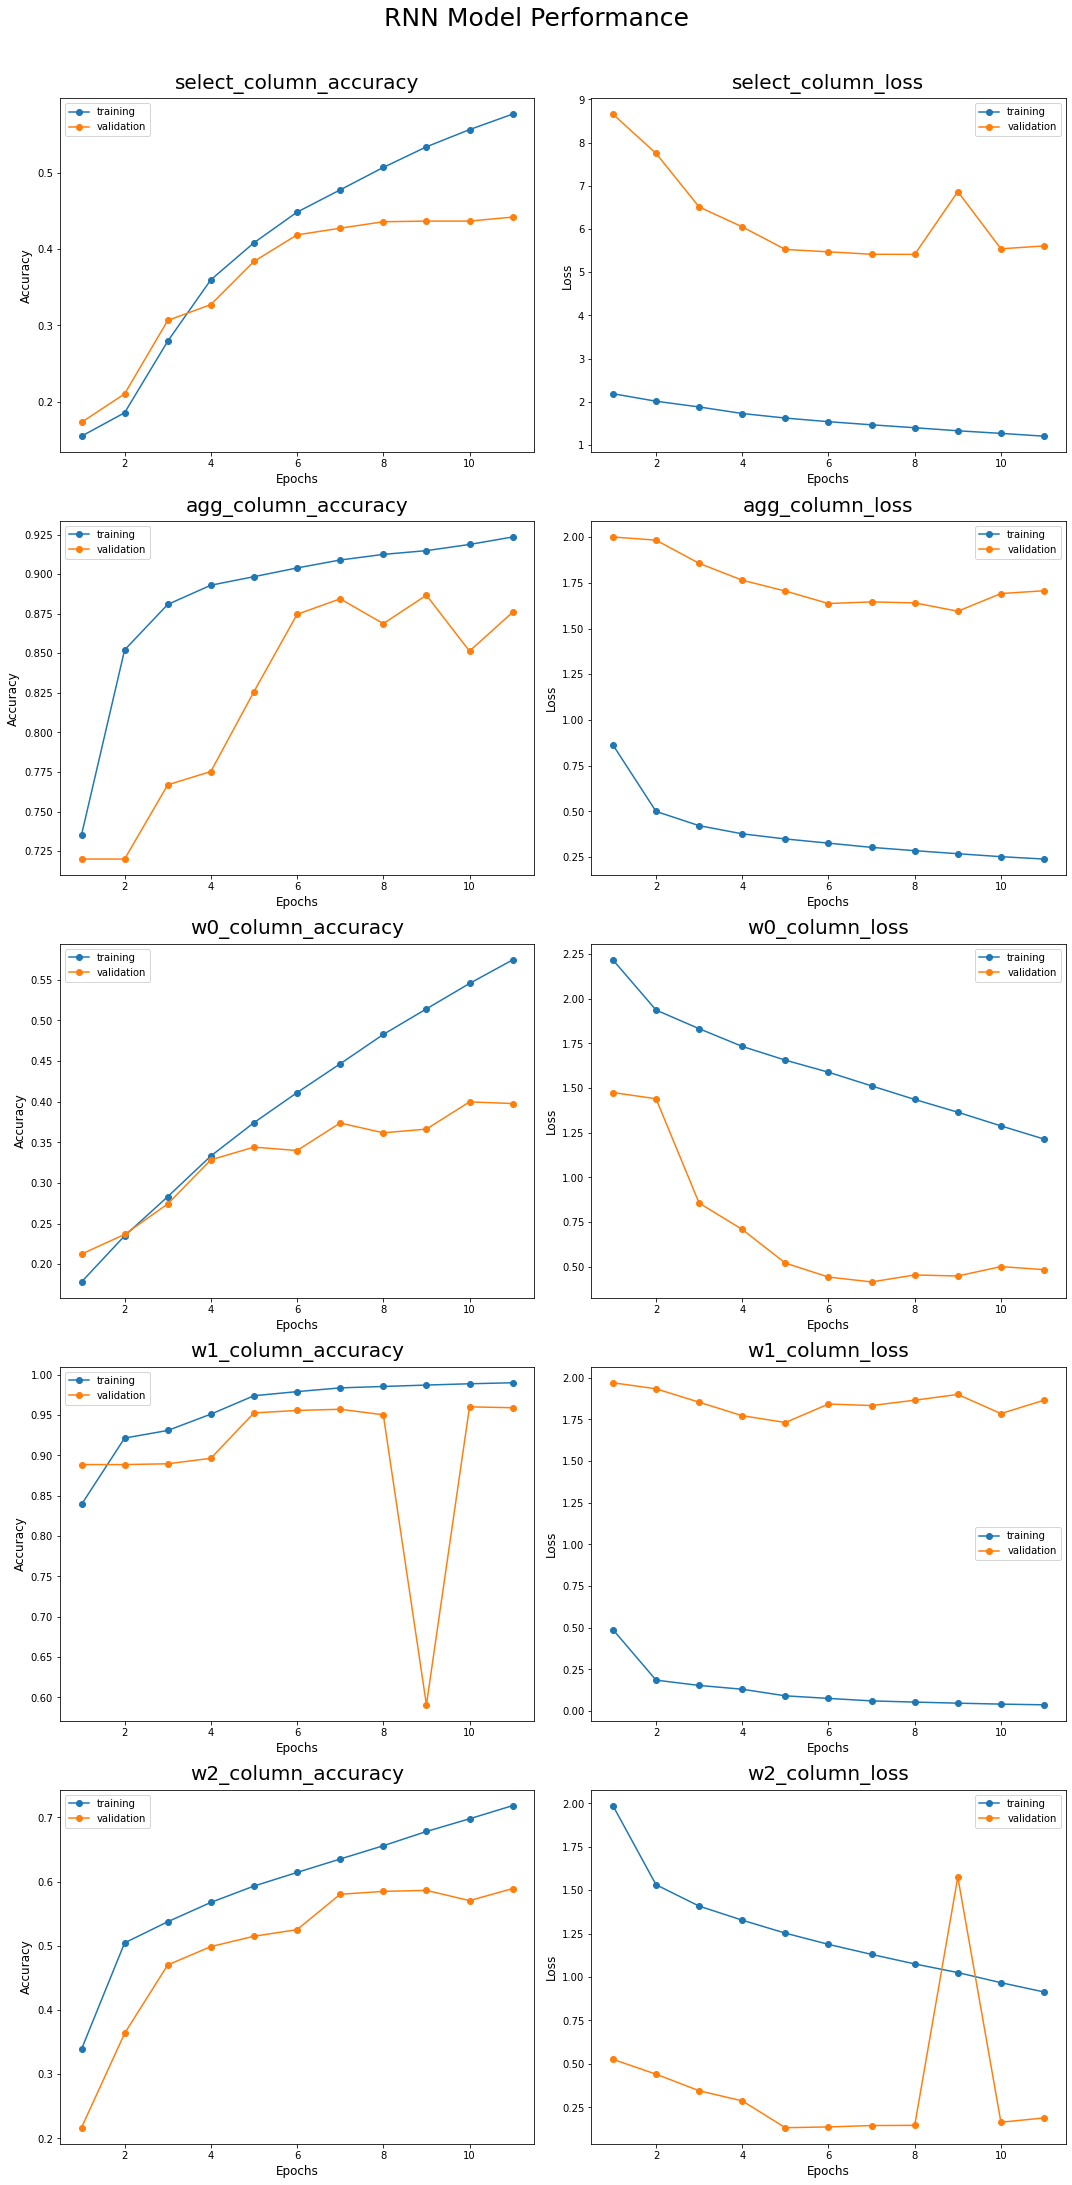

In [23]:
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))

# For loop for the five outputs
for i in range(5):
    # For loop for loss or accuracy plot
    for j in range(2):
        # Plot loss Vs. epoch on first figure column
        if j == 0:
            epochs = range(1,len(history.history['loss'])+1)
            train = list(history.history.keys())[i+6]
            val = list(history.history.keys())[i+17]
            ax[i, j].plot(epochs, history.history[train], label="training", marker="o")
            ax[i, j].plot(epochs, history.history[val], label="validation", marker="o")
            ax[i, j].set_title(train,size = 20,y=1.01)
            ax[i, j].set_xlabel("Epochs", size = 12)
            ax[i, j].set_ylabel("Accuracy", size = 12)
            ax[i, j].legend()
        # Plot accuracy Vs. epoch on second figure column
        if j == 1:
            epochs = range(1,len(history.history['loss'])+1)
            train = list(history.history.keys())[i+1]
            val = list(history.history.keys())[i+11]
            ax[i, j].plot(epochs, history.history[train], label="training", marker="o")
            ax[i, j].plot(epochs, history.history[val], label="validation", marker="o")
            ax[i, j].set_title(train,size = 20, y=1.01)
            ax[i, j].set_xlabel("Epochs", size = 12)
            ax[i, j].set_ylabel("Loss", size = 12)
            ax[i, j].legend()

fig.suptitle("RNN Model Performance", size = 25, y=1.01)
fig.tight_layout()

The model stopped training at epoch 11 because of the `early_stop` callback.


Looking at the plots above we can see that in all the outputs the `train` accuracy curve is always above the `validation` accuracy curve and both have a growing trend.

For some of the columns the model is overfitting because the `train` and `validation` curves are moving apart from each other (definitely for select_column, first_where_column and third_where_column).

Loss functions on the other hand are dropping over the epochs (aside from the second_where_column where both curves are constant). The `train` loss curve should always be below the `validation` loss curve but in some cases it's above (first_where_column and third_where_column).

It's also interesting to notice that the validation accuracy of second_where_column (`w1_column_accuracy`) drops consistently at epoch 9 (And goes back up) but not on the train set, and there is no sign of changing in the loss function. This is quite unexpected and might be related to the learning rate.

## Results

Let's make the predictions on the `test`set and check the model accuracies on it.

In [24]:
test_pred = RNN_model.predict(X_test_tok)

In [25]:
test_pred_sel = np.argmax(test_pred[0], axis=1) 
test_pred_agg = np.argmax(test_pred[1], axis=1) 
test_pred_w0 = np.argmax(test_pred[2], axis=1) 
test_pred_w1 = np.argmax(test_pred[3], axis=1) 
test_pred_w2 = np.argmax(test_pred[4], axis=1) 

In [26]:
print(f"Test Accuracy Select column: {accuracy_score(y_test['select_col'], test_pred_sel)}")
print(f"Test Accuracy Agg column: {accuracy_score(y_test['agg_col'], test_pred_agg)}")
print(f"Test Accuracy first where column: {accuracy_score(y_test['first_where_col_0'], test_pred_w0)}")
print(f"Test Accuracy second where column: {accuracy_score(y_test['first_where_col_1'], test_pred_w1)}")
print(f"Test Accuracy third where column: {accuracy_score(y_test['first_where_col_2'], test_pred_w2)}")

Test Accuracy Select column: 0.4182383946148473
Test Accuracy Agg column: 0.8731821934336699
Test Accuracy first where column: 0.3528291103067251
Test Accuracy second where column: 0.9544040134628818
Test Accuracy third where column: 0.574014097923414


The accuracy results are very similar with what we noticed with the `Classifier Chain`.

The accuracy on the `Agg` column and `second where column` are quite good (87% and 95%) because the model had fewer classes to chose from, 5 and 3 respectively.

All the other outputs, where the classes are 10 to 11, have lower accuracies (42%, 35% and 57%). These accuracies are actually not bad if we consider that a random classifier would 10% probability of predicting the right class (on a 10-class output).

Because of the class imbalance we have in all the outputs, accuracy is not the best metric for the problem. We are now going to have a look at the confusion matrix of each output.

In [27]:
# Make the list of the five predictions
test_pred_list = [test_pred_sel, test_pred_agg, test_pred_w0, test_pred_w1, test_pred_w2]
# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(len(test_pred_list)): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred_list[i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

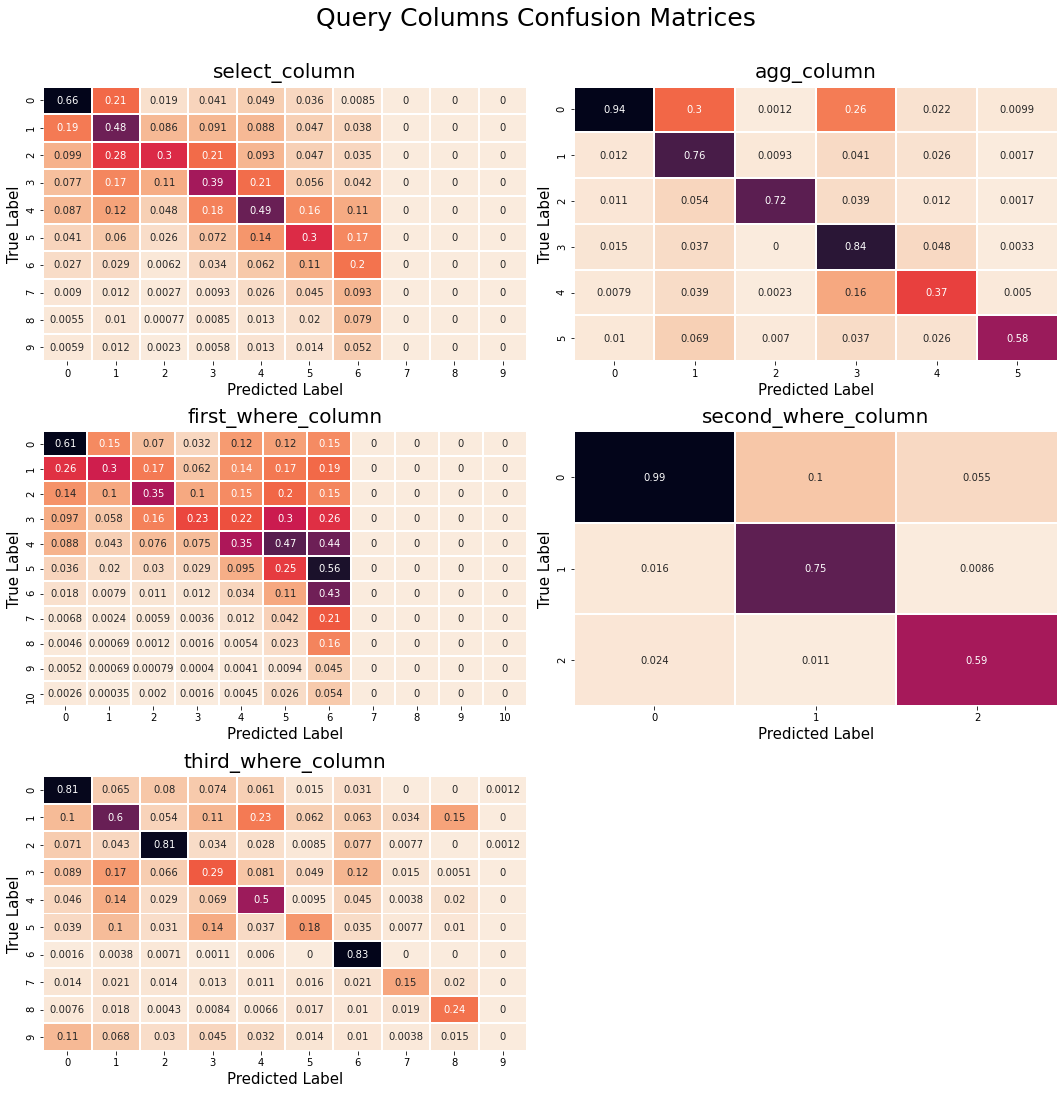

In [28]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])

As suspected, the class imbalance has a good influence on the predictions of the models. 

The higher the numbers (close to 1) along the diagonal the better the model is performing (true predictions). Same as for the `Classifier Chain`, in this RNN model we see some good performance on some of the classes but also some pretty bad one on others. If we look at the class distribution we can correlate the result. The model predict very well classes that are more frequent in the `train` set but has a hard time to predict less frequent classes.

Some of the predicted output columns (select_column, first_where_column and third_where_column) have `0`s in the matrices because the model was not exposed to these classes and/or did not predict them. 

Class imbalance has a huge influence on the RNN model prediction, more than the `Classifier Chain` apparently.

Let's save the model.

In [29]:
RNN_model.save("s2s")

INFO:tensorflow:Assets written to: s2s/assets


This is the end of Jupyter Notebook 4 of 6. In the next one we'll try to deal with the class imbalance to see if we can improve the RNN model performance.